# Simulation code

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import statsmodels.api as sm

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [2]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

## Test statistics TR

In [3]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]


    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Test statistics LSTR

In [4]:
def cal_g_theta_LSTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     LSTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Test statistics ESTR


In [5]:
def cal_g_theta_ESTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     ESTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

In [6]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

## Simulation 1

In [7]:
def MonteCarlo_1(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_1(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_1(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the corresponding lost function of interest
        delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size,T_size)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)

    
def sim_model_1(T_size):

    # Initialize delta1, delta2 and v
    delta1 = delta2 = v = 1

    # Simulate the model
    z1 = np.random.normal(0,1,(T_size,1))
    z2 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z1 + delta2 * z2 + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size):
    
    # Compile z1 and z2
    sim_z1 = np.column_stack([np.ones((T_size,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T_size,1)),sim_z2])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z1_sel = sim_z1[t-R_size:t-1]
        z2_sel = sim_z2[t-R_size:t-1]
        y_sel = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        # Estimate the two forecasts
        forecast1 = beta_1[0] + sim_z1[t,1] * beta_1[1]
        forecast2 = beta_2[0] + sim_z2[t,1] * beta_2[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2
    
    # Return the vector of the loss function of interest
    return delta_L

In [8]:
#simulation speed:
MC_iterations = 2000
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = False

print("---TR model---")
model_type = "TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---LSTR model---")
model_type = "LSTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---ESTR model---")
model_type = "ESTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TR model---
For R = 25
And P = 50


<ipython-input-7-75f661859cca>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i] = MonteCarlo_iteration_1(R,P,T)


KeyboardInterrupt: 

# Simulation 2

In [9]:
def MonteCarlo_2(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_2)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_2(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_2(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_2(delta_L_1,sim_S_t[R_size-1:T_size-1],c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_2(R_size, P_size, T_size)


def cal_delta_L_2(delta_L_old,S_sel,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
    
    # Return the loss function of interest
    return delta_L

In [10]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 1000
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Values for P to loop over
P_MC_array = [50,100,200]

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.014
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.013
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 100
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.032
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

KeyboardInterrupt: 

[0.1 0.  0.1 0.4 0.8 0.8 0.9 0.9 0.9 1.  1. ]


KeyboardInterrupt: 

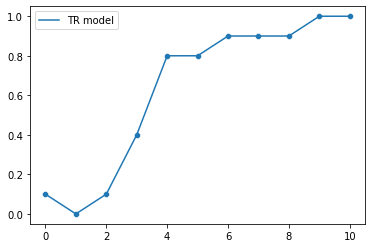

In [11]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 1000
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
P_MC_array = [50,100,200]
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
        
model_type = "LSTR"
signi_level = 0.014
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='LSTR model')
        
model_type = "ESTR"
signi_level = 0.013
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='LSTR model')
    
model_type = "ESTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Simulation 3

In [12]:
def MonteCarlo_3(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_3)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        value_delta_L = np.array([result[1] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        value_delta_L = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], value_delta_L[i] = MonteCarlo_iteration_3(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array), np.mean(value_delta_L)

def MonteCarlo_iteration_3(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        
        # Simulate the model
        sim_z_t, sim_y_t, sim_S_t = sim_model_3(T_size)
        
        # Calculate the corresponding lost function of interest
        if (window_type=="ROLREC"):
            delta_L = cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="ROLFIX"):
            delta_L = cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="RECFIX"):
            delta_L = cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        else:
            raise Exception("Window type unknown")
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), (np.sum(delta_L > 0) / P_size > 0.5).astype(int)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_3(R_size, P_size, T_size)

    
def sim_model_3(T_size):

    # Initialize delta and v
    delta = v = 1

    # Simulate the model
    z_t = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta * z_t + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z_t, y_t, S_t


def cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size, T_size):
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_ROL = sim_z_t[t-R_size:t-1]
        z_sel_REC = sim_z_t[0:t-1]
        y_sel_ROL = sim_y_t[t-R_size:t-1]
        y_sel_REC = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta_ROL = estimateBeta(z_sel_ROL,y_sel_ROL)
        beta_REC = estimateBeta(z_sel_REC,y_sel_REC)
        
        # Estimate the two forecasts
        forecast_ROL = beta_ROL[0] + sim_z_t[t,1] * beta_ROL[1]
        forecast_REC = beta_REC[0] + sim_z_t[t,1] * beta_REC[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_ROL)**2 - (sim_y_t[t] - forecast_REC)**2

    # Return the vector of the loss function of interest
    return delta_L

def cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size, T_size):
    
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    z_sel_FIX = sim_z_t[0:R_size-1]
    y_sel_FIX = sim_y_t[0:R_size-1]
    
    beta_FIX = estimateBeta(z_sel_FIX,y_sel_FIX)
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_ROL = sim_z_t[t-R_size:t-1]
        y_sel_ROL = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_ROL = estimateBeta(z_sel_ROL,y_sel_ROL)

        # Estimate the two forecasts
        forecast_ROL = beta_ROL[0] + sim_z_t[t,1] * beta_ROL[1]
        forecast_FIX = beta_FIX[0] + sim_z_t[t,1] * beta_FIX[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_ROL)**2 - (sim_y_t[t] - forecast_FIX)**2

    # Return the vector of the loss function of interest
    return delta_L

def cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size, T_size):
    
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    z_sel_FIX = sim_z_t[0:R_size-1]
    y_sel_FIX = sim_y_t[0:R_size-1]
    
    beta_FIX = estimateBeta(z_sel_FIX,y_sel_FIX)
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_REC = sim_z_t[0:t-1]
        y_sel_REC = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta_REC = estimateBeta(z_sel_REC,y_sel_REC)

        # Estimate the two forecasts
        forecast_REC = beta_REC[0] + sim_z_t[t,1] * beta_REC[1]
        forecast_FIX = beta_FIX[0] + sim_z_t[t,1] * beta_FIX[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_REC)**2 - (sim_y_t[t] - forecast_FIX)**2

    # Return the vector of the loss function of interest
    return delta_L

In [13]:
#simulation speed:
MC_iterations = 2000
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = True
model_type = "TR"


print("---ROLREC model---")
window_type = "ROLREC"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---ROLFIX model---")
window_type = "ROLFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---RECFIX model---")
window_type = "RECFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)

---ROLREC model---
For R = 25
And P = 50


<ipython-input-12-a7d70d5b1be4>:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], value_delta_L[i] = MonteCarlo_iteration_3(R,P,T)


KeyboardInterrupt: 

# Simulation 4

In [14]:
def MonteCarlo_4(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_4)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        value_delta_L = np.array([result[1] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        value_delta_L = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], value_delta_L[i] = MonteCarlo_iteration_4(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array), np.mean(value_delta_L)

def MonteCarlo_iteration_4(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        
        # Simulate the model
        sim_z_t, sim_y_t, sim_S_t = sim_model_4(T_size)

        # Calculate the corresponding lost function of interest
        if (window_type=="ROLREC"):
            delta_L = cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="ROLFIX"):
            delta_L = cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="RECFIX"):
            delta_L = cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        else:
            raise Exception("Window type unknown")
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), (np.sum(delta_L > 0) / P_size > 0.5).astype(int)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_4(R_size, P_size, T_size)

    
def sim_model_4(T_size):

    # Initialize and v
    v = 1
    
    steps = np.random.normal(0, 0.1, size=T_size)
    delta_t = (np.cumsum(steps) + 1).reshape(T_size,1)

    # Simulate the model
    z_t = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta_t * z_t + np.random.normal(0, 1, (T_size,1))
    # Return parameter vectors
    return z_t, y_t, S_t

In [15]:
#simulation speed:
MC_iterations = 2000
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = True
barlett_kernel = True
model_type = "TR"


print("---ROLREC model---")
window_type = "ROLREC"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---ROLFIX model---")
window_type = "ROLFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---RECFIX model---")
window_type = "RECFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)

---ROLREC model---
For R = 25
And P = 50


KeyboardInterrupt: 

# Simulation 5

In [16]:
def MonteCarlo_5(R,P,T):
    
    if (parallelization == True):    
        
        # Define variable to keep track of amount of rejects
        loss_mean = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_5)(R,P,T) for i in range(MC_iterations))
                
    else:
        loss_mean = np.zeros(P)    
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            loss_mean += (MonteCarlo_iteration_5(R,P,T))

    # Return the rejection rate
    return loss_mean / MC_iterations

def MonteCarlo_iteration_5(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        # Simulate the model
        sim_z_1, sim_z_2, sim_z_3, sim_z_4, sim_y_t, sim_S_t = sim_model_5(T_size)

        delta_L = cal_delta_L_5(sim_z_1, sim_z_2, sim_z_3, sim_z_4, sim_y_t, R_size, P_size,T_size)
        
        return np.transpose(np.absolute(delta_L))[0]
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_5(R_size, P_size, T_size)

    
def sim_model_5(T_size):

    # Initialize and v
    v = 1
    delta1 = 0.1
    delta2 = 0
    delta3 = 0.1
    delta4 = 0
    
    # Simulate the model
    z_1 = np.random.normal(0,1,(T_size,1))
    z_2 = np.random.normal(0,1,(T_size,1))
    z_3 = np.random.normal(0,1,(T_size,1))
    z_4 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z_1 + delta2 * z_2 + delta3 * z_3 + delta4 * z_4 + np.random.normal(0, 1, (T_size,1))
    
    # Return parameter vectors
    return z_1, z_2, z_3, z_4, y_t, S_t

def cal_delta_L_5(sim_z_1,sim_z_2, sim_z_3, sim_z_4, sim_y_t, R_size, P_size,T_size):
    
    # Compile z_t
    sim_z_t1 = np.column_stack([np.ones((T_size,1)),sim_z_1,sim_z_2])
    sim_z_t2 = np.column_stack([np.ones((T_size,1)),sim_z_3,sim_z_4])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
        
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel1 = sim_z_t1[0:t-1]
        z_sel2 = sim_z_t2[0:t-1]
        y_sel = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta1 = estimateBeta(z_sel1,y_sel)
        beta2 = estimateBeta(z_sel2,y_sel)
        
        # Estimate the two forecasts
        forecast1 = beta1[0] + sim_z_t1[t,1] * beta1[1] + sim_z_t1[t,2] * beta1[2]
        forecast2 = beta2[0] + sim_z_t2[t,1] * beta2[1] + sim_z_t2[t,2] * beta2[2]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2 
    # Return the vector of the loss function of interest
    return delta_L

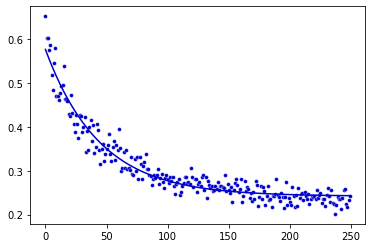

In [17]:
#simulation speed:
MC_iterations = 500

# Values for P to loop over
R_MC = 25
P_MC = 250

# Adjustable variables
parallelization = False

# for i in range(len(P_MC_array)):
T_MC = R_MC + P_MC
loss_array = MonteCarlo_5(R_MC,P_MC,T_MC)

sns.scatterplot(x=np.arange(P_MC), y=loss_array,color='mediumblue',s=15)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

import scipy.optimize 

params, cv = scipy.optimize.curve_fit(monoExp, np.arange(P_MC), loss_array, (2, .5, 50))
m, t, b = params
sns.lineplot(x=np.arange(P_MC), y=monoExp(np.arange(P_MC), m, t, b),color='mediumblue')

plt.show()

# New Models

In [18]:
def TV_TR_model(S_t, gamma,kappa,T_size):
    return ((S_t >= gamma).astype(float) / (np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))).reshape(-1, 1)

def TV_LSTR_model(S_t,gamma,tau,kappa,T_size):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

def TV_ESTR_model(S_t,gamma,tau,kappa,T_size):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

In [19]:
def cal_g_theta_TV_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and kappa values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    kappa_array = np.repeat(np.linspace(0,2,grid_elements),grid_elements)
    
    # Get Q_t
    Q_t = np.stack([np.column_stack(((np.exp(-kappa_array[i]*np.arange(0,T_size)/T_size).reshape(T_size,1)),TV_TR_model(S_t,np.quantile(S_t,gamma_quantile[i]),kappa_array[i],T_size)))
                                                                     for i in range(grid_elements**2)])

    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]
    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)
    
    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0


# Simulation 6

In [20]:
#simulation speed:
MC_iterations = 2000
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = True
barlett_kernel = False

print("---TV-TR model---")
model_type = "TV-TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TV-TR model---
For R = 25
And P = 50
The rejection rate is 0.3
For R = 25
And P = 100


KeyboardInterrupt: 

# Simulation 7

In [21]:
def MonteCarlo_7(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_7)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_7(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_7(delta_L_1,sim_S_t[R_size-1:T_size-1],T_size,R_size,c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_7(R_size, P_size, T_size)


def cal_delta_L_7(delta_L_old,S_sel,T_size,R_size,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
   
    delta_L = delta_L / (np.exp(1 * np.arange(T_size)/T_size)[R_size-1:T_size-1]).reshape(-1,1)

    # Return the loss function of interest
    return delta_L

In [22]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 1000
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC

# model_type = "TR"
# signi_level = 0.035
# print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

# model_type = "TV-TR"
# signi_level = 0.008
# print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.036
print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

model_type = "TV-TR"
signi_level = 0.034
print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

KeyboardInterrupt: 

In [23]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 2000
grid_elements = 20
iterations_CV = 1000
c_length = 2

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = False
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.035
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')

model_type = "TV-TR"
signi_level = 0.008
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.036
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.034
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

<ipython-input-21-a74c8182fce8>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)


KeyboardInterrupt: 